In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.applications.resnet import preprocess_input

from keras import Model
from keras.applications import ResNet50
from keras.layers import LSTM, Dense, Input, Add, Embedding, Dropout, TextVectorization, Concatenate, Flatten
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import math
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import nltk
nltk.download('stopwords')

DATASET_PATH = '/Projects/coursework/flicker8k_dataset/'
SEQ_LENGTH = 20


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading dataset

In [2]:
def load_dataset(file_path):
    with open(DATASET_PATH + file_path) as file:
        images = []
        captions = []
        
        for line in file.readlines():
            line = line.rstrip("\n")
            image_name, caption = line.split('\t')
            image_name = image_name[:-2]
        
            images.append(image_name)
            captions.append(caption)
            
        return images, captions
    
images, captions = load_dataset('Flickr8k.token.txt')

In [3]:
def load_image_data(img_name):
    image_path = tf.io.gfile.join(DATASET_PATH, 'Flicker8k_images/', img_name)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    image_data = preprocess_input(image_data)
    return image_data

def display_image(img_name):
    image_path = tf.io.gfile.join(DATASET_PATH, 'Flicker8k_images/', img_name)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    return image_data

### Testing data loading

3720210639_18bb34e475.jpg
Person doing bicycle jump


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


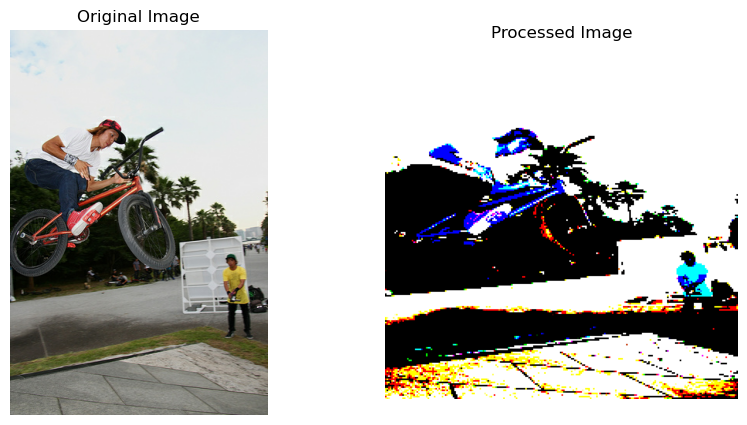

In [4]:
test_idx = np.random.randint(len(images))
test_image = images[test_idx]

print(test_image)
print(captions[test_idx])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(display_image(test_image))
plt.title("Original Image")
plt.axis('off')  

plt.subplot(1, 2, 2)
plt.imshow(load_image_data(test_image))
plt.title("Processed Image")
plt.axis('off')  

plt.show()

### Vectorizing captions

In [5]:
STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(text):
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word not in STOP_WORDS]
    text = " ".join(filtered_words)
    return text

captions = [remove_stop_words(caption) for caption in captions]

In [6]:
def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", "")
    text = tf.strings.regex_replace(text, r'[0-9]', '')
    text = tf.strings.join(['<START> ', text, ' <END>'])
    return text

text_vectorizer = TextVectorization(
    max_tokens=None, 
    output_mode='int',  
    output_sequence_length=SEQ_LENGTH,  
    standardize=custom_standardization,  
)

text_vectorizer.adapt(captions)

vocab = text_vectorizer.get_vocabulary()

VOCAB_SIZE = text_vectorizer.vocabulary_size()

idx_to_word = {i: word for i, word in enumerate(vocab)}

vectorized_captions = text_vectorizer(captions)


### Testing text vectorizer

In [7]:
test_idx = np.random.randint(len(captions))

caption = vectorized_captions[test_idx]
test_caption = []

print(captions[test_idx])
print(caption)

for index in caption: 
    test_caption.append(idx_to_word[int(index)])
    
print('\n')    
print(test_caption)



dog runs across green lush grass .
tf.Tensor(
[   2    4   52   94   38 2099   26    3    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)


['<START>', 'dog', 'runs', 'across', 'green', 'lush', 'grass', '<END>', '', '', '', '', '', '', '', '', '', '', '', '']


### Mapping captions to images

In [8]:
def map_captions_to_images(images, captions):
    caption_mappings = {}
    
    for i in range(len(images)):
        if images[i] not in caption_mappings: 
            caption_mappings[images[i]] = []
            
        caption_mappings[images[i]].append(captions[i])
    
    return caption_mappings
    
caption_mappings = map_captions_to_images(images, vectorized_captions)

### Testing caption mappings

In [9]:
test_idx = np.random.randint(len(captions))

for caption in caption_mappings[images[test_idx]]:
    test_caption = []
    for index in caption: 
        test_caption.append(idx_to_word[int(index)])
    print(test_caption)

['<START>', 'brown', 'dog', 'jumping', 'fence', 'another', 'dog', 'chasing', '<END>', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'brown', 'dog', 'jumps', 'wire', 'fence', 'another', 'dog', 'follows', '<END>', '', '', '', '', '', '', '', '', '', '']
['<START>', 'dog', 'jumping', 'fence', 'another', 'dog', 'grass', 'background', '<END>', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'dog', 'jumping', 'gate', 'followed', 'another', 'dog', '<END>', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'small', 'tan', 'dog', 'jumping', 'chain', 'linked', 'fence', '<END>', '', '', '', '', '', '', '', '', '', '', '']


In [10]:
unique_images = list(caption_mappings.keys())
training_images, validation_images = train_test_split(unique_images, train_size=0.8)

print('Training size: {}'.format(len(training_images)))
print('Validation size: {}'.format(len(validation_images)))


Training size: 6472
Validation size: 1619


In [11]:
HIDDEN_DIM = 256
EMB_DIM = 300
EPOCHS = 50
BATCH_SIZE = 32
STEPS = math.ceil(len(training_images) / BATCH_SIZE)
VAL_STEPS = math.ceil(len(validation_images) / BATCH_SIZE)

# Model 

In [12]:
encoder = ResNet50(weights= 'imagenet', include_top= False, pooling='avg')
encoder.trainable = False

In [13]:
encoder.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [14]:
# images features model path
input_img = Input(shape=(2048,))
cnn_layer1 = Dropout(.4)(input_img)
cnn_layer2 = Dense(256, activation = 'relu')(cnn_layer1)

# sequences path
input_seq = Input(shape=(SEQ_LENGTH,))
lstm_layer1 = Embedding(VOCAB_SIZE,300,input_length = SEQ_LENGTH , mask_zero = True )(input_seq)
lstm_layer2 = Dropout(.4) (lstm_layer1)
lstm_layer3 = LSTM(256,activation='tanh') (lstm_layer2)

merging_layer = Concatenate()([cnn_layer2, lstm_layer3])
final_dense = Dense(256 , activation ='relu')(merging_layer)
output = Dense(VOCAB_SIZE , activation ='softmax')(final_dense)

decoder_model = Model(inputs = [input_img,input_seq] , outputs = output )

decoder_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      2601000     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

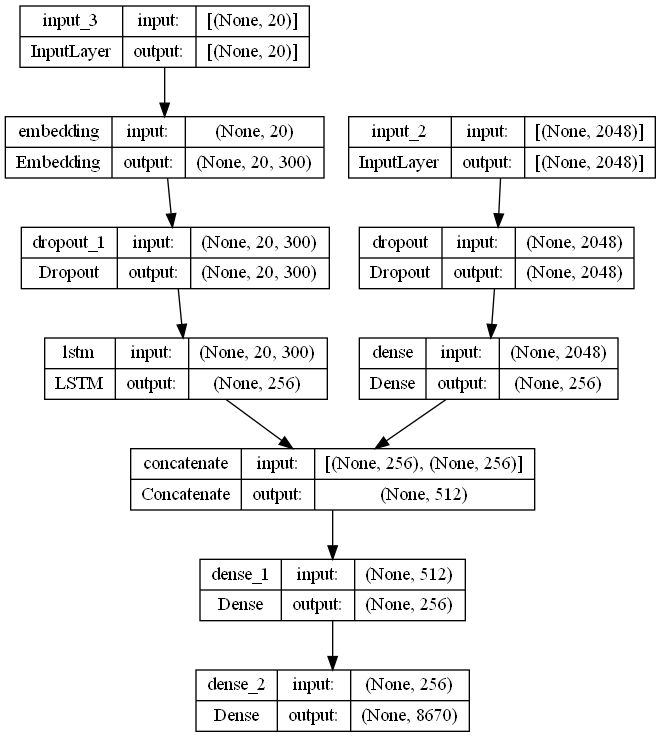

In [15]:
plot_model(decoder_model, show_shapes = True)

# Data Generator 

In [16]:
def create_batches(images, batch_size):
    for i in range(0, len(images), batch_size):
        yield images[i:i + batch_size]        
        
def batch_extract_features(images):
    feature_mappings = {}
    
    for batch in create_batches(images, 1024):
        image_data = [load_image_data(img_path) for img_path in batch] 
        image_data = tf.convert_to_tensor(image_data)     

        extracted_features = encoder.predict(image_data, verbose=1)

        for i, img_features in enumerate(extracted_features):
            img_name = batch[i]
            feature_mappings[img_name] = img_features

        del image_data
        del extracted_features
        
        tf.keras.backend.clear_session()
        import gc
        gc.collect()

    with open("feature_mappings.pkl", "wb") as file:
            pickle.dump(feature_mappings, file)
    
    return feature_mappings

In [17]:
# with open("feature_mappings.pkl", "rb") as file:
#     feature_mappings = pickle.load(file)
    
# if len(feature_mappings) ==0: 
#     feature_mappings = batch_extract_features(images)

In [18]:
feature_mappings = batch_extract_features(unique_images)

29/29 [==============================] - 2s 37ms/step


In [39]:
def data_generator(list_of_images):
    x1, x2, y = [], [], []
    current_batch_size = 0 
    
    # np.random.shuffle(images)
    while True:
        for image in list_of_images:
            features = feature_mappings[image]
            captions = caption_mappings[image]
            
            # np.random.shuffle(captions)
                                
            for sequence in captions:
                for index in range(1, len(sequence)):
                    input_seq = sequence[:index]
                    label = sequence[index]
                    if label != 0:               
                        x1.append(features)
                        x2.append(input_seq)
                        y.append(label)
                    
            current_batch_size += 1

            if current_batch_size == BATCH_SIZE:
                try :
                    x2 = pad_sequences(x2, maxlen = SEQ_LENGTH, padding='post')
                    y = to_categorical(y, num_classes=VOCAB_SIZE)
                    yield [tf.convert_to_tensor(x1), tf.convert_to_tensor(x2)], tf.convert_to_tensor(y)
                except GeneratorExit:
                    print("Generator is being closed")
                    raise 
                
                x1, x2, y = [], [], []
                current_batch_size = 0


In [40]:
sample_caption = text_vectorizer(["test"])[0].numpy()
start_token = sample_caption[0]
end_token = sample_caption[2]

def decode_caption(caption):
    decoded_caption = []
    
    for word in caption: 
        if word == start_token or word == 0:
            continue
        if word == end_token: 
            break
        else: 
            token =  idx_to_word[word] 
            decoded_caption.append(token) 
            
    return decoded_caption
    
def generate_caption(image):
    features = feature_mappings[image]
    features = np.expand_dims(features, axis= 0)
   
    caption = [start_token]
    caption = pad_sequences([caption], maxlen=SEQ_LENGTH, padding='post')
        
    for i in range(1, SEQ_LENGTH):       
        prediction = decoder_model.predict([features, caption], verbose = 0)[0]
        word_idx = np.argmax(prediction)
          
        caption[0][i] = word_idx
        
        if word_idx == end_token:
            break
                
    return decode_caption(caption[0])

In [41]:
test_batch = data_generator(images)

for batch in test_batch:
    print(batch[0][0].shape)
    print(batch[0][1].shape) 
    print(batch[1].shape) 
    print()
    
    for i in range(10): 
        print(batch[0][0][i].shape)
        print(batch[0][1][i])
        print(decode_caption(batch[0][1][i].numpy()))
        print(batch[1][i].shape)
        print(np.argmax(batch[1][i]))
    break

Generator is being closed
(1178, 2048)
(1178, 20)
(1178, 8670)

(2048,)
tf.Tensor([2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32)
[]
(8670,)
27
(2048,)
tf.Tensor([ 2 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32)
['child']
(8670,)
63
(2048,)
tf.Tensor([ 2 27 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32)
['child', 'pink']
(8670,)
135
(2048,)
tf.Tensor(
[  2  27  63 135   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int32)
['child', 'pink', 'dress']
(8670,)
89
(2048,)
tf.Tensor(
[  2  27  63 135  89   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int32)
['child', 'pink', 'dress', 'climbing']
(8670,)
344
(2048,)
tf.Tensor(
[  2  27  63 135  89 344   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int32)
['child', 'pink', 'dress', 'climbing', 'set']
(8670,)
341
(2048,)
tf.Tensor(
[  2  27  63 135 

In [42]:
optimizer = Adam(learning_rate=0.001)

loss = CategoricalCrossentropy()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [43]:
decoder_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [44]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
validation_data = data_generator(validation_images)
training_data = data_generator(training_images)

training = decoder_model.fit(training_data, epochs=1, steps_per_epoch=STEPS, validation_data=validation_data, validation_steps=VAL_STEPS)

In [ ]:
# decoder_model.save('saved-models/lstm-encoder')

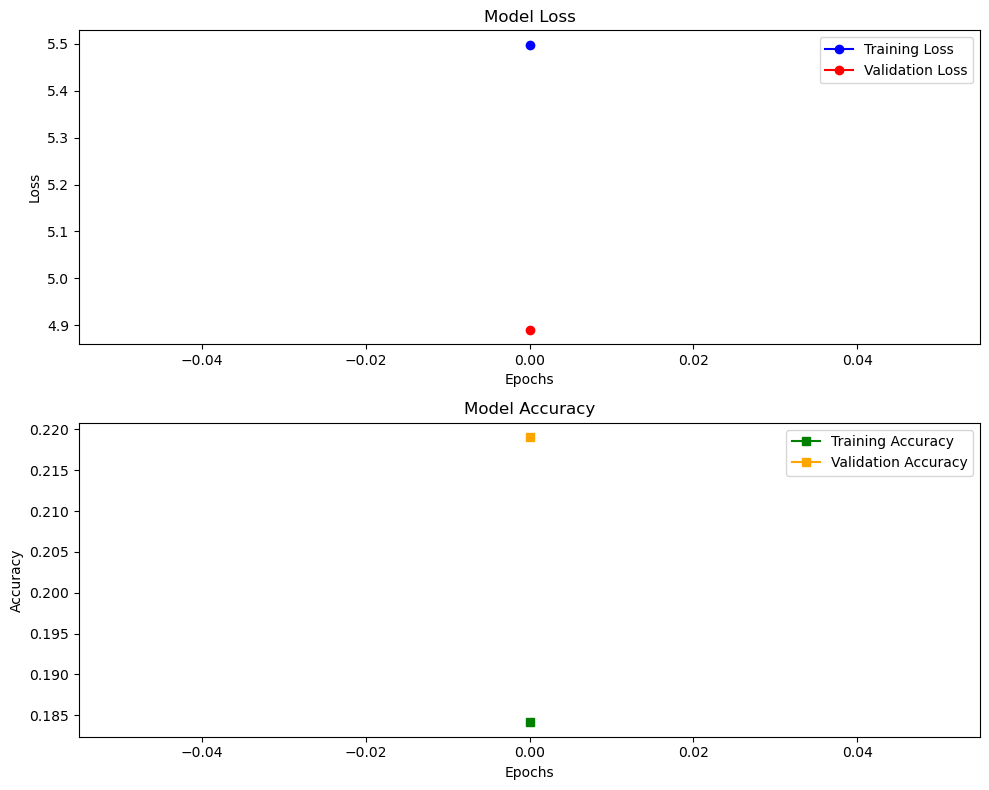

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

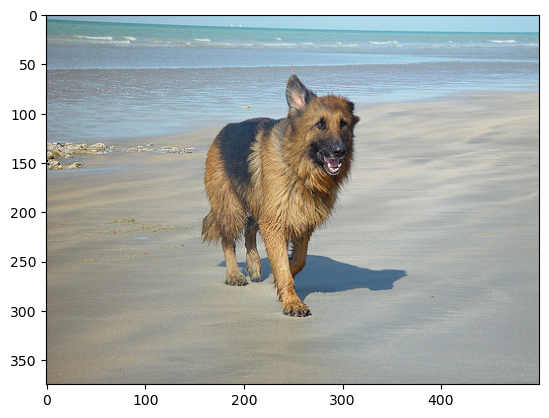

dog running

True captions: 
brown black dog walking beach
fluffy dog walks along sandy beach
medium sized dog beach
dog walking beach ocean
one brown black dog standing sand beach


In [ ]:
test_image = np.random.choice(validation_images)
test_data = feature_mappings[test_image]
plt.imshow(display_image(test_image))
plt.show()
prediction = generate_caption(test_image)
print(' '.join(prediction))
true_captions = caption_mappings[test_image]
print('\nTrue captions: ')
for caption in true_captions: 
    print(' '.join(decode_caption(caption.numpy())))

In [ ]:
def BLEU_evaluation(images):
    smoothing_function = SmoothingFunction().method4  # Choose an appropriate smoothing method

    bleu_scores = []
    bleu_4_weights = (.25, .25, .25, .25)

    for image in images:
        predicted = generate_caption(image)
                
        actual_encoded = caption_mappings[image]
        actual = []
        
        for caption in actual_encoded:
            caption = caption.numpy()
            caption = decode_caption(caption)
            actual.append((caption))
            
        score = sentence_bleu(actual, predicted, bleu_4_weights, smoothing_function)
        bleu_scores.append(score)
    
    print(bleu_scores)
        
    return np.mean(bleu_scores)


In [ ]:
BLEU_evaluation(validation_images)

KeyboardInterrupt: 